In [6]:
!pip install gymnasium

In [7]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [8]:
SEED = 422
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
X = 0
Y = 1
NO_RUNS = 10
ACTIONS_NAMES = ['↓', '→','↑', '←']

ACTION_SPACE = [LEFT, DOWN, RIGHT, UP]
# Plot configs
P_LAYOUT = go.Layout(
    autosize = False,
    width = 1000,
    height = 600,
    margin = go.layout.Margin(l=50, r=50, b=50, t=100, pad=10),
)

In [9]:
import numpy as np
import pygame

import gymnasium as gym
from gymnasium import spaces
import random


class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 24}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location, "obstacle": np.array(self.tree)}



    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }


    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.power = 100
        self.health=100
        self.agent_set = [0,1,2,6,7,12]
        self.target_set = [23,28,29,33,34,35]
        self._all = list(range(self.size**2))


        self._agent_location = self.np_random.choice(self.agent_set)
        self._target_location = self.np_random.choice(self.target_set)
        self.target_agent = [self._agent_location,self._target_location]
        # print(self.target_agent)
        self.obstacle_list = [x for x in self._all if x not in self.target_agent]
        size = self.size
        self.border_list = []
        # print(self.target_agent)
        for i in range(0,size*size):
            if(i<size):
                self.border_list.append(i)
            elif(i>size-1 and i<size*(size-1) and i%size==0):
                self.border_list.append(i)
                self.border_list.append(i+size-1)
            elif(i>size*(size-1)-1):
                self.border_list.append(i)
        self.border_list =  [x for x in self.border_list if x not in self.target_agent]
        self.not_border_list =  [x for x in self.obstacle_list if x not in self.border_list]
        # Choose the agent's location uniformly at random
        self._agent_location = np.array(tuple(reversed(divmod(self._agent_location,self.size))))
        self._target_location = np.array(tuple(reversed(divmod(self._target_location,self.size))))


        # print(self.obstacle_list)

        border_tree = 0
        self.tree = []
        for i in range(0,8):
            # print(i)
            if(i<2):
                temp_obs = self.np_random.choice(self.obstacle_list)
                temp_obs_t = tuple(reversed(divmod(temp_obs,self.size)))

                self.tree.append(temp_obs_t)
                self.obstacle_list.remove(temp_obs)
                if temp_obs in self.border_list:
                    border_tree+=1
                if temp_obs in self.border_list:
                    self.border_list.remove(temp_obs)
                elif temp_obs in self.not_border_list:
                    self.not_border_list.remove(temp_obs)
            if(i>1):
                # print(i)
                while True:
                    # print(border_tree)
                    if(border_tree==2):
                        temp_obs = self.np_random.choice(self.not_border_list)
                        temp_obs_t = tuple(reversed(divmod(temp_obs,self.size)))
                        distance = abs(np.subtract(temp_obs_t,self.tree))
                        next_to = []
                        for j in range(0,len(distance)):
                            if sum(distance[j])==1 and np.prod(distance[j])==0:
                                next_to.append(j)
                        # print(len(next_to))
                        if(len(next_to)>1):
                            # print(temp_obs)
                            self.obstacle_list.remove(temp_obs)
                            self.not_border_list.remove(temp_obs)

                        elif(len(next_to)==0):
                            # print(temp_obs_t)
                            self.tree.append(temp_obs_t)
                            self.obstacle_list.remove(temp_obs)
                            self.not_border_list.remove(temp_obs)
                            break

                        elif(len(next_to)==1):
                            distance2 = abs(np.subtract(self.tree,self.tree[next_to[0]]))
                            # print(distance2)
                            next_to2 = []

                            for k in range(0,len(distance2)):

                                if (sum(distance2[k])==1 and np.prod(distance2[k])==0):
                                    next_to2.append(k)
                            # print(next_to2)

                            if(len(next_to2)==0):
                                    self.tree.append(temp_obs_t)
                                    self.obstacle_list.remove(temp_obs)
                                    self.not_border_list.remove(temp_obs)
                                    break
                            else:
                                self.obstacle_list.remove(temp_obs)
                                self.not_border_list.remove(temp_obs)
                    elif(border_tree<2):
                        temp_obs = self.np_random.choice(self.obstacle_list)
                        temp_obs_t = tuple(reversed(divmod(temp_obs,self.size)))
                        # print(temp_obs_t)
                        distance = abs(np.subtract(temp_obs_t,self.tree))
                        next_to = []
                        for j in range(0,len(distance)):
                            if sum(distance[j])==1 and np.prod(distance[j])==0:
                                next_to.append(j)

                        if(len(next_to)>1):
                            self.obstacle_list.remove(temp_obs)
                            if temp_obs in self.border_list:
                                self.border_list.remove(temp_obs)
                            elif temp_obs in self.not_border_list:
                                self.not_border_list.remove(temp_obs)
                        elif(len(next_to)==0):
                            # print(temp_obs_t)
                            self.tree.append(temp_obs_t)
                            self.obstacle_list.remove(temp_obs)
                            if temp_obs in self.border_list:
                                border_tree+=1
                                self.border_list.remove(temp_obs)
                            if temp_obs in self.not_border_list:
                                self.not_border_list.remove(temp_obs)
                            break

                        elif(len(next_to)==1):
                            distance2 = abs(np.subtract(self.tree,self.tree[next_to[0]]))
                            next_to2 = []
                            for m in range(0,len(distance2)):
                                if (sum(distance2[m])==1 and np.prod(distance2[m])==0):
                                    next_to2.append(m)

                            if(len(next_to2)==0):
                                    self.tree.append(temp_obs_t)
                                    self.obstacle_list.remove(temp_obs)
                                    if temp_obs in self.border_list:
                                        border_tree+=1
                                        self.border_list.remove(temp_obs)

                                    if temp_obs in self.not_border_list:
                                        self.not_border_list.remove(temp_obs)
                                    break
                            else:
                                if temp_obs in self.border_list:
                                    self.border_list.remove(temp_obs)
                                elif temp_obs in self.not_border_list:
                                    self.not_border_list.remove(temp_obs)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info ,self.tree




    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        action_probability = [0,1,2]
        selected_action = np.random.choice(action_probability,p=[0.8,0.1,0.1])
        direction = self._action_to_direction[action]
        if selected_action==0:
            self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
            )

        elif selected_action==1:
            self._agent_location = np.clip(
            self._agent_location + direction - direction, 0, self.size - 1
            )

        elif selected_action==2:
            direction = -1*direction
            self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
            )


        # We use `np.clip` to make sure we don't leave the grid

        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        tree_crash = np.any(np.all(np.array(self.tree).reshape(8,2) == self._agent_location, axis=1))

        # Binary sparse rewards
        np.random.normal(-1,0.5)
        if terminated:
            reward = np.random.normal(25,5)
            self.power = self.power - np.random.normal(0.35,0.15)
        elif tree_crash:
            reward = np.random.normal(-1,0.5)
            self._agent_location = np.clip(
            self._agent_location - direction, 0, self.size - 1
            )
            self.health-= np.random.normal(0.35,0.15)
        else:
            reward = np.random.normal(-0.5,0.25)
            self.power-= np.random.normal(0.2,0.1)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info , self.power ,self.health

    def take_action(self,epslion,current_state,Q):
        prob = np.random.uniform()
        S = current_state['agent']
        if(prob<epslion):
            action_to_take = np.random.choice(4,1)[0]
        else:
            action_to_take = np.argmax(Q[S[0]][S[1]])

        return action_to_take
    def find_next_states(self,action,current_state):

        direction = self._action_to_direction[action]
        same_action = np.clip(
            current_state + direction, 0, self.size - 1)
        reverse_action = np.clip(
            current_state - direction, 0, self.size - 1)
        no_action = np.array(current_state)
        next_possible_states = [same_action,reverse_action,no_action]
        states_probabilities = [0.8,0.1,0.1]

        # print(next_possible_states)

        tree_crash = []

        for i in range(0,len(next_possible_states)):

            if any(np.array_equal(next_possible_states[i], element) for element in np.array(tree_locs).reshape(8,2)):
                tree_crash.append(True)
                # print(next_possible_states)
            else:
                tree_crash.append(False)
        # print(self._target_location)
        is_ends = [np.array_equal(x, self._target_location) for x in next_possible_states]

        return next_possible_states,states_probabilities,tree_crash,is_ends

    def update_Q_learning(self,reward,current_state,next_state,action,Q,lr_):
        self.lr = lr_
        discountf = 0.9
        S = current_state['agent']
        NS = next_state['agent']
        max_state_action = np.argmax(Q[S[0]][S[1]])
        Q[S[0]][S[1]][action] = Q[S[0]][S[1]][action] + self.lr*(reward + discountf*Q[NS[0]][NS[1]][max_state_action]-Q[S[0]][S[1]][action])
        return Q

    def update_Q_sarsa(self,reward,current_state,next_state,action,Q,epsilon,lr_):
        self.lr = lr_
        discountf = 0.9
        S = current_state['agent']
        NS = next_state['agent']
        next_state_action = self.take_action(epsilon,next_state,Q)

        Q[S[0]][S[1]][action] = Q[S[0]][S[1]][action] + self.lr*(reward + discountf*Q[NS[0]][NS[1]][next_state_action]-Q[S[0]][S[1]][action])
        return Q


    def next_states(self,state_agent):
        next_possible_actions = []
        for x in [[0, -1], [+1, 0], [0, +1], [-1, 0]]:
            next_state = np.clip(
                    state_agent +x , 0, 5)
            if np.all(np.any((np.array(self.tree)).reshape(8,2) != next_state, axis=1)):
                if(next_state.tolist() not in next_possible_actions):
                    next_possible_actions.append(next_state.tolist())
        return next_possible_actions





def MC_Q_update(states_,actions_,Q_matrix,rewards_):
        first_visit = []
        return_ = []
        for i in range(len(states_)):
            disc_return = 0
            # print((states_[i]))
            if(tuple(states_[i]) not in first_visit):
                first_visit.append(tuple(states_[i]))

                for j in range(len(rewards_)-1,i,-1):
                    disc_return+=rewards_[j]*((0.9))
                return_.append(disc_return)

            Q_matrix[states_[i][0]][states_[i][1]][actions_[i]] = sum(return_)/len(return_)
        return Q_matrix,sum(rewards_)


def plot_values(data):
  data = np.round(data, decimals=2)
  ax = sns.heatmap(data, annot=True, fmt='.2f', cmap='viridis', cbar=True)
  ax.set_title('State Values')
  plt.show()



In [10]:
class PolicyIteration():
    def __init__(self, env, discount, theta):
        self.env = env
        self.discount = discount
        self.theta = theta

        self.reset()

    def policy_evaluation(self):
        self.delta = np.inf

        while(self.delta > self.theta):

            self.delta = 0

            for state in itertools.product(range(self.env.size), range(self.env.size)):
                punish = 0
                if any(np.array_equal(state, tree) for tree in self.env.tree):
                    punish = -100

                for action in ACTION_SPACE:
                    # print(action)


                    next_states,states_probabilities,tree_crash,is_ends = self.env.find_next_states(
                        action = action,
                        current_state = (state[X], state[Y]),
                    )
                    next_state_rewards = np.array([
                        -0.5 + int(is_ends[s_i]) * 25 + int(tree_crash[s_i]) * -10
                        for s_i in range(len(next_states))
                    ], dtype=float)

                    # Belman Equation
                    next_states = np.array(next_states).reshape(len(next_states),2)
                    next_state_values = self.state_values[next_states[:, X], next_states[:, Y]]
                    self.q_values[state[X], state[Y], action] = np.sum(
                        states_probabilities * (next_state_rewards + self.discount * next_state_values),
                    )

                v = self.state_values[state[X], state[Y]]

                optimal_action = self.optimal_policy[state[X]][state[Y]]
                self.state_values[state[X], state[Y]] = self.q_values[state[X], state[Y], optimal_action] + punish

                self.delta = np.max([self.delta, abs(v - self.state_values[state[X], state[Y]])])

    def policy_improvement(self):
        self.policy_stable = True
        old_policy = self.optimal_policy.copy()
        for state in itertools.product(range(self.env.size), range(self.env.size)):
            self.optimal_policy[state[X], state[Y]] = self.get_optimal_policy([state[X], state[Y]])
        if not (old_policy == self.optimal_policy).all():
            self.policy_stable = False

    def fit(self):
        while(not self.policy_stable):
            self.policy_evaluation()
            self.policy_improvement()

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state[X], state[Y], :])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        self.env.reset(seed=SEED)
        self.delta = 0
        self.state_values = np.zeros((self.env.size, self.env.size))
        self.q_values = np.zeros((self.env.size, self.env.size, 4))
        self.optimal_policy = np.random.randint(4, size=(self.env.size, self.env.size))
        self.policy_stable = False

In [11]:
def run_algorithms(algorithm):
  env = GridWorldEnv(size=6)
  observation,infoo,tree_locs = env.reset(seed=SEED)
  Q_matrix = np.zeros((6,6,4))

  all_rewards = []
  for i in range(750):
      observation,info,tree_locs = env.reset(seed=SEED)
      epsilon = 100/(i+100)
      # lr_ = 10/(100+i)
      lr_ = 0.1
      rewards_ = []
      states_ = []
      actions_ = []
      while True:

          #taking action
          action = env.take_action(epsilon,observation,Q_matrix)

          next_observation, reward, terminated,TF, info,power,health = env.step(action)

          #Q_learning
          if(algorithm=="Q_learning"):
            Q_matrix = env.update_Q_learning(reward,observation,next_observation,action,Q_matrix,lr_)

          #SARSA
          elif(algorithm=="SARSA"):
            Q_matrix = env.update_Q_sarsa(reward,observation,next_observation,action,Q_matrix,epsilon,lr_)

          #MC
          states_.append(observation['agent'])
          rewards_.append(reward)
          actions_.append(action)


          if(power<5 or health<15 or terminated):
              break
          observation = next_observation
      all_rewards.append(rewards_)

  return all_rewards,Q_matrix



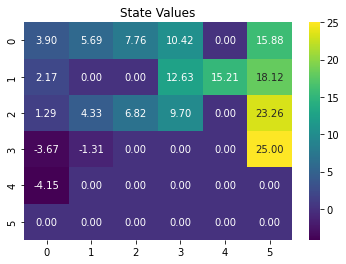

In [12]:
rewards_agents = []
for i in range(NO_RUNS):
    all_rewards_SARSA,qvals = run_algorithms("SARSA")
    mean_rewards = [sum(episode) for episode in all_rewards_SARSA]
    rewards_agents.append(mean_rewards)

size = 6
state_values = np.zeros((size, size))
for state in itertools.product(range(size), range(size)):
    state_values[state[0]][state[1]] = max(qvals[state[0]][state[1]][:])

plt.figure()
state_values[3,5] = 25
plot_values(state_values)
plt.show()
ACTIONS_NAMES = ['↓', '→','↑', '←']
actions = [[ACTIONS_NAMES[np.argmax(qvals[i][j][:])] for j in range(6)] for i in range(6)]
actions[3][5] = '*'
fig = go.Figure(data=go.Heatmap(
    z = abs(state_values),
    text = actions,
    texttemplate = '%{text}',
))
fig.update_layout(P_LAYOUT, title=dict(text='Optimal Policy'))
fig.update_xaxes(side='top', constrain='domain')
fig.update_yaxes(autorange='reversed', scaleanchor='x')
actions
fig.show()

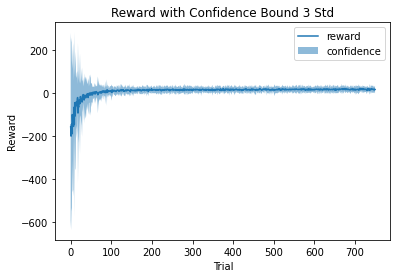

In [13]:
mean = [sum(x)/NO_RUNS for x in zip(*rewards_agents)]
transposed_lists = np.array(rewards_agents).T
std = [np.std(position) for position in transposed_lists]
upper = np.array(mean) + 3*np.array(std)
lower = np.array(mean) - 3*np.array(std)
fig, ax = plt.subplots()
ax.plot(mean, label="reward")
ax.fill_between(np.arange(len(mean)), lower ,upper , alpha=0.5, label="confidence")
ax.set_xlabel("Trial")
ax.set_ylabel("Reward")
ax.set_title("Reward with Confidence Bound 3 Std")
plt.legend()
plt.show()

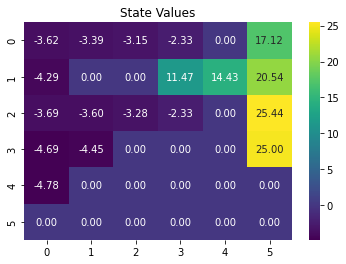

In [14]:
rewards_agents = []
for i in range(NO_RUNS):
    all_rewards_Q_learning,qvals = run_algorithms("Q_learning")
    mean_rewards = [sum(episode) for episode in all_rewards_Q_learning]
    rewards_agents.append(mean_rewards)

size = 6
state_values = np.zeros((size, size))
for state in itertools.product(range(size), range(size)):
    state_values[state[0]][state[1]] = max(qvals[state[0]][state[1]][:])

plt.figure()
state_values[3,5] = 25
plot_values(state_values)
plt.show()
actions = [[ACTIONS_NAMES[np.argmax(qvals[i][j][:])] for j in range(6)] for i in range(6)]
actions[3][5] = '*'
fig = go.Figure(data=go.Heatmap(
    z = abs(state_values),
    text = actions,
    texttemplate = '%{text}',
))
fig.update_layout(P_LAYOUT, title=dict(text='Optimal Policy'))
fig.update_xaxes(side='top', constrain='domain')
fig.update_yaxes(autorange='reversed', scaleanchor='x')
actions
fig.show()

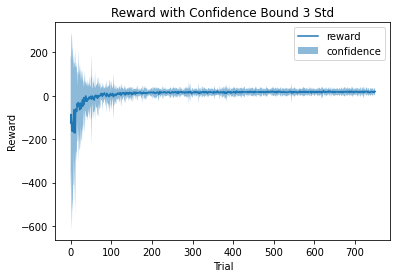

In [15]:
mean = [sum(x)/NO_RUNS for x in zip(*rewards_agents)]
transposed_lists = np.array(rewards_agents).T
std = [np.std(position) for position in transposed_lists]
upper = np.array(mean) + 3*np.array(std)
lower = np.array(mean) - 3*np.array(std)
fig, ax = plt.subplots()
ax.plot(mean, label="reward")
ax.fill_between(np.arange(len(mean)), lower ,upper , alpha=0.5, label="confidence")
ax.set_xlabel("Trial")
ax.set_ylabel("Reward")
ax.set_title("Reward with Confidence Bound 3 Std")
plt.legend()
plt.show()

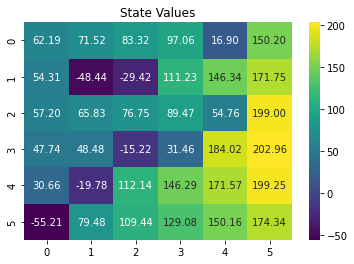

In [16]:
import time
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt
env =   GridWorldEnv(size=6)
observation,info,tree_locs = env.reset(seed=SEED)
PI = PolicyIteration(env,0.9,1e-6)

PI.fit()
data = np.round(PI.get_state_values(), decimals=2)
data
ax = sns.heatmap(data, annot=True, fmt='.2f', cmap='viridis', cbar=True)
ax.set_title('State Values')
plt.show()

In [17]:

actions = [[ACTIONS_NAMES[np.argmax(PI.get_q_values()[i][j][:])] for j in range(6)] for i in range(6)]
actions[3][5] = '*'
fig = go.Figure(data=go.Heatmap(
    z = abs(PI.get_state_values()),
    text = actions,
    texttemplate = '%{text}',
))
fig.update_layout(P_LAYOUT, title=dict(text='Optimal Policy'))
fig.update_xaxes(side='top', constrain='domain')
fig.update_yaxes(autorange='reversed', scaleanchor='x')
actions
fig.show()